In [44]:
# Importing necessary libraries
from matplotlib import legend
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import os
import numpy as np
from icecream import ic
from tqdm import tqdm
from itertools import chain
from get_data import *
import logging
import os

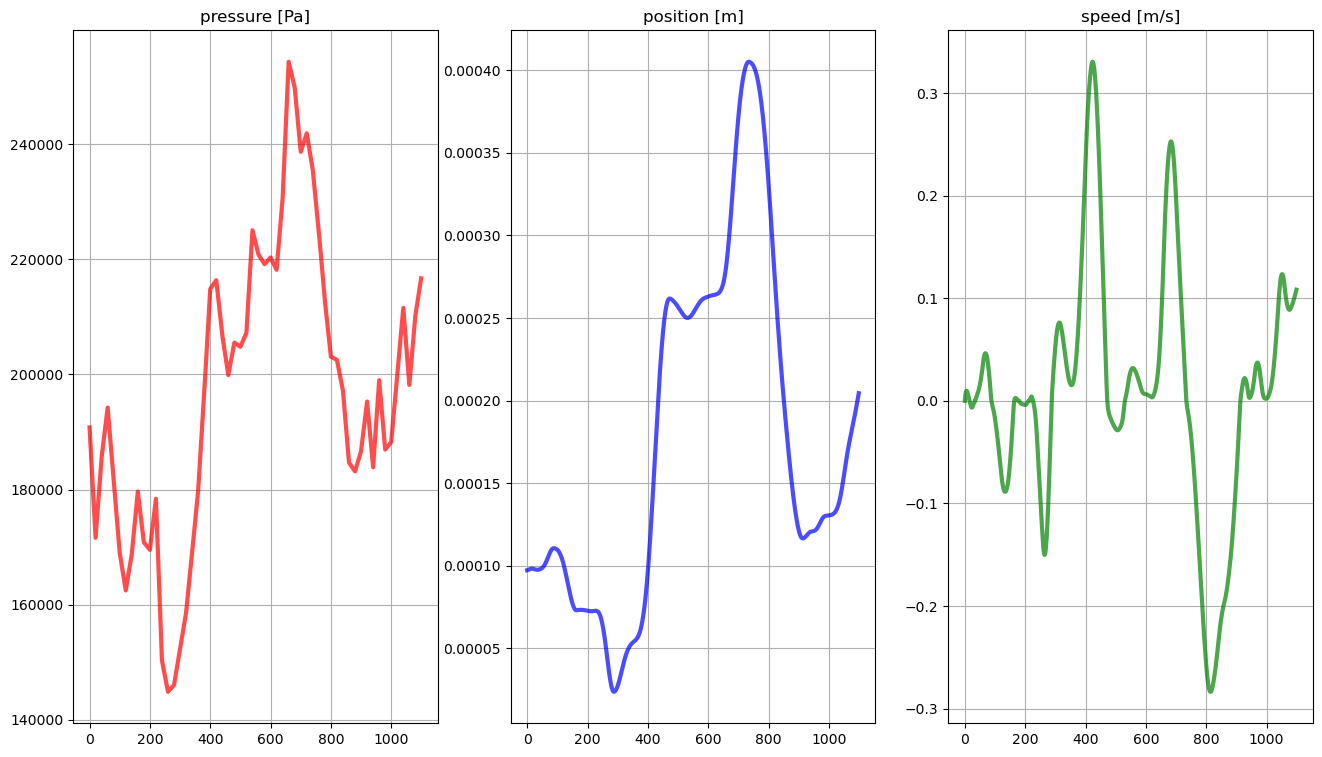

In [45]:
visualise(get_data(path = "save_data_test3.csv", timesteps_from_data=0, skip_steps_start = 0, skip_steps_end = 0, drop_half_timesteps = False, normalise_s_w=False, rescale_p=False, num_inits=0), num_inits=20)

In [46]:
 #Define the LSTM model with two hidden layers
torch.set_default_dtype(torch.float64)
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)
class LSTMmodel(nn.Module):
    """
    LSTM model class for derivative estimation.
    """

    def __init__(self, input_size, hidden_size, out_size, layers):
        """
        Initialize the LSTM model.

        Args:
        - input_size: Size of input
        - hidden_size: Size of hidden layer
        - out_size: Size of output
        - layers: Number of layers
        """
        super().__init__()

        self.hidden_size = hidden_size
        self.input_size = input_size

        # Define LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=layers, batch_first=True)

        # Define linear layer
        self.linear = nn.Linear(hidden_size, out_size)

    def forward(self, seq):
        """
        Forward pass through the LSTM model.

        Args:
        - seq: Input sequence

        Returns:
        - pred: Model prediction
        - hidden: Hidden state
        """
        lstm_out, hidden = self.lstm(seq)
        pred = self.linear(lstm_out)

        return pred, hidden


cuda:0


In [51]:
def test(test_data, model, steps=600, ws=10, plot_opt=False):

    #test_data = test_dataloader.get_all_data() 
    model.eval()
    loss_fn = nn.MSELoss()
    test_loss = 0
    test_loss_deriv = 0
    total_loss = 0

    for i, x in enumerate(test_data):
        x=x.to(device)
        if i > 5:
            break

        with torch.inference_mode():

            pred = torch.zeros((steps, 3), device=device)
            pred_next_step = torch.zeros((steps, 3), device=device)

            if ws > 1:
                pred[0:ws, :] = x[0:ws, :]
                pred[:, 0] = x[:, 0]
                pred_next_step[0:ws, :] = x[0:ws, :]
                pred_next_step[:, 0] = x[:, 0]
            else:
                pred[0, :] = x[0, :]
                pred[:, 0] = x[:, 0]
                pred_next_step[0, :] = x[0, :]
                pred_next_step[:, 0] = x[:, 0]

            for i in range(len(x) - ws):

                out, _ = model(pred[i:i+ws, :])
                pred[i+ws, 1:] = pred[i+ws-1, 1:] + out[-1, :]
                pred_next_step[i+ws, 1:] = x[i+ws-1, 1:] + out[-1, :]
            
            test_loss += loss_fn(pred[:, 1], x[:, 1]).detach().cpu().numpy()
            test_loss_deriv += loss_fn(pred[:, 2], x[:, 2]).detach().cpu().numpy()

            total_loss += loss_fn(pred[:, 1:], x[:, 1:]).detach().cpu().numpy()

            if plot_opt:
                figure , axs = plt.subplots(1,3,figsize=(16,9))
            
                axs[0].plot(pred.detach().cpu().numpy()[:, 1], color="red", label="pred")
                axs[0].plot(pred_next_step.detach().cpu().numpy()[:, 1], color="green", label="next step from data")
                axs[0].plot(x.detach().cpu().numpy()[:, 1], color="blue", label="true", linestyle="dashed")
                axs[0].set_title("position")
                axs[0].grid()
                axs[0].legend()

                axs[1].plot(pred.detach().cpu().numpy()[:, 2], color="red", label="pred")
                axs[1].plot(pred_next_step.detach().cpu().numpy()[:, 2], color="green", label="next step from data")
                axs[1].plot(x.detach().cpu().numpy()[:, 2], color="blue", label="true", linestyle="dashed")
                axs[1].set_title("speed")
                axs[1].grid()
                axs[1].legend()

                axs[2].plot(x.detach().cpu().numpy()[:,0], label="pressure")
                axs[2].set_title("pressure")
                axs[2].grid()
                axs[2].legend()

                plt.grid()
                plt.legend()
                plt.show()
            
    return np.mean(test_loss), np.mean(test_loss_deriv), np.mean(total_loss)

In [ ]:

def get_data(path = "ventil_lstm\save_data_test.csv", timesteps_from_data=100, skip_steps_start = 1, skip_steps_end = 1, drop_half_timesteps = True, normalise_s_w=False, rescale_p=False, num_inits=0):
    
    if timesteps_from_data>1:
     df = pd.read_csv(path, header=0, nrows=timesteps_from_data, skiprows=skip_steps_start)
    else:
     df = pd.read_csv(path, header=0, skiprows=skip_steps_start)

    if skip_steps_end>1:
       df = df.iloc[0:len(df)-skip_steps_end]

    #drop even more timesteps
    if drop_half_timesteps:
     df = df.iloc[::2]

    if num_inits>1:
       df = df.iloc[:,0:4*num_inits]
    #Reorder columns for familiar setup (t,u,x) here (t, p_b, s_b, w_b)
    L = df.columns.to_list()
    time_cols = L[0::4]
    sb_cols = L[1::4]
    pb_cols = L[2::4]
    wb_cols = L[3::4]
    new_col_order = [x for sub in list(zip(time_cols, pb_cols, sb_cols, wb_cols)) for x in sub]
    df= df[new_col_order]
    df = df.drop(time_cols, axis=1)

    #normalise each column of the dataframe
    #mean normalization
    #df=(df-df.mean())/df.std()
    
    #Can't normalize p_b because then a[i]*X+b[i] becomes cX+d for all i.. same with mean normal. 
    
    # Normalise / Rescale
    if normalise_s_w:
        tmp=pb_cols+sb_cols+wb_cols
        df[tmp]=(df[tmp]-df[tmp].min())/(df[tmp].max()-df[tmp].min())
    if rescale_p:
        df[pb_cols] = df[pb_cols] / 1e5

    tensor = torch.tensor(df.values)

    #tensor with t=0:600, 500 different input and the 3 outputs [s_b, p_b, w_b]
    a = num_inits if num_inits>0 else 500
    tensor = tensor.view(len(df),a,3).permute(1,0,2)

    return tensor


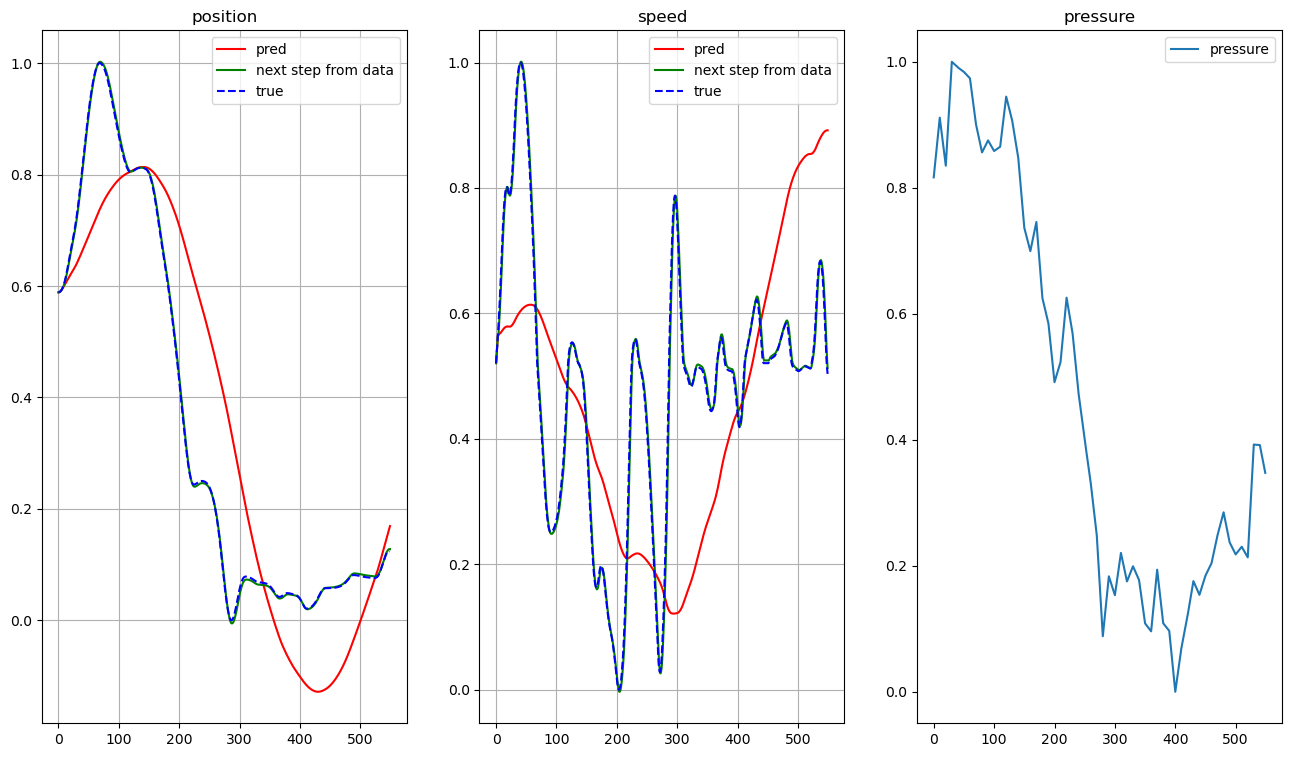

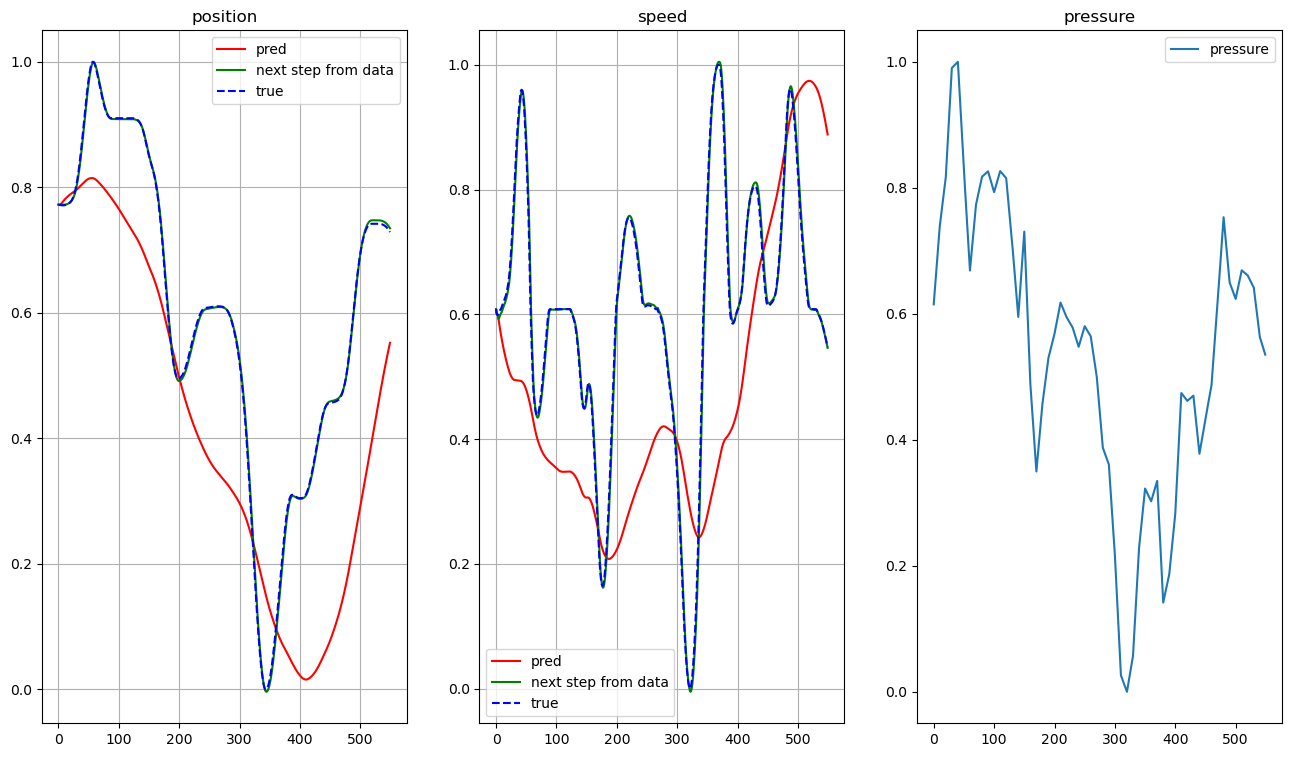

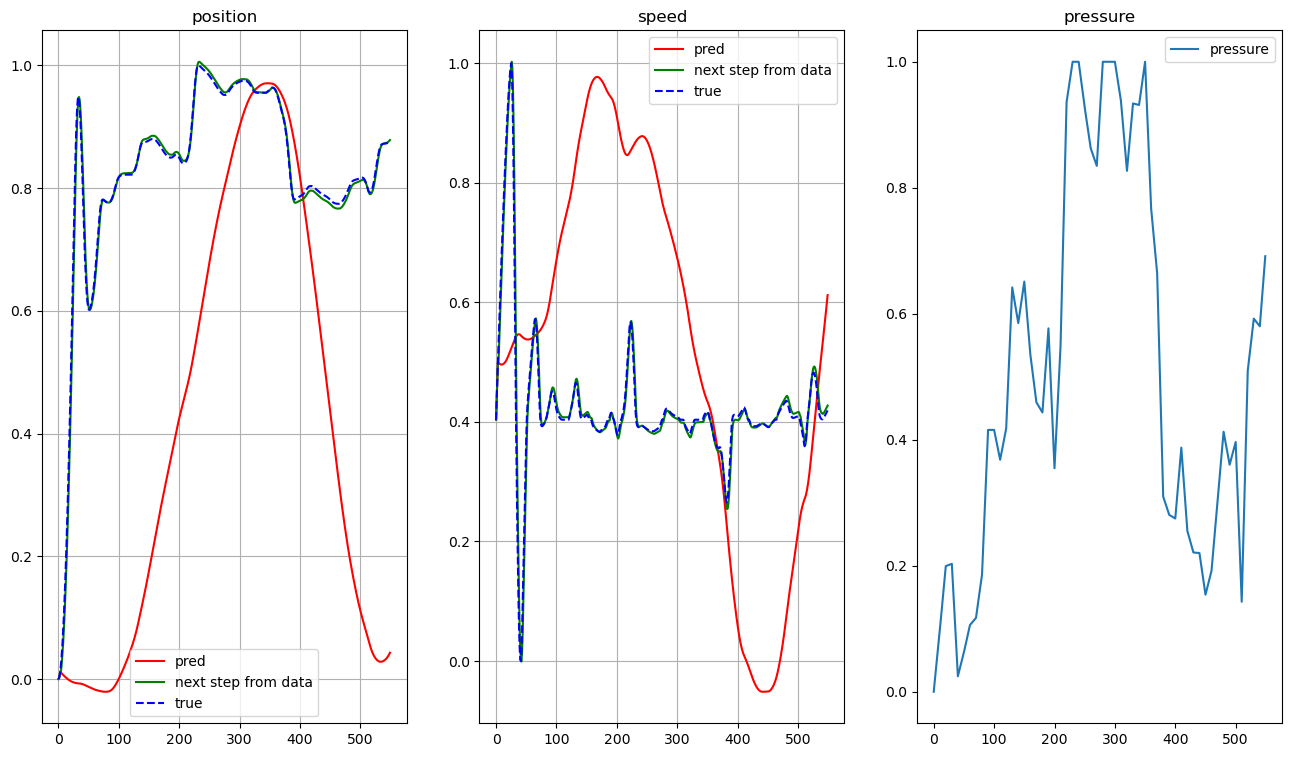

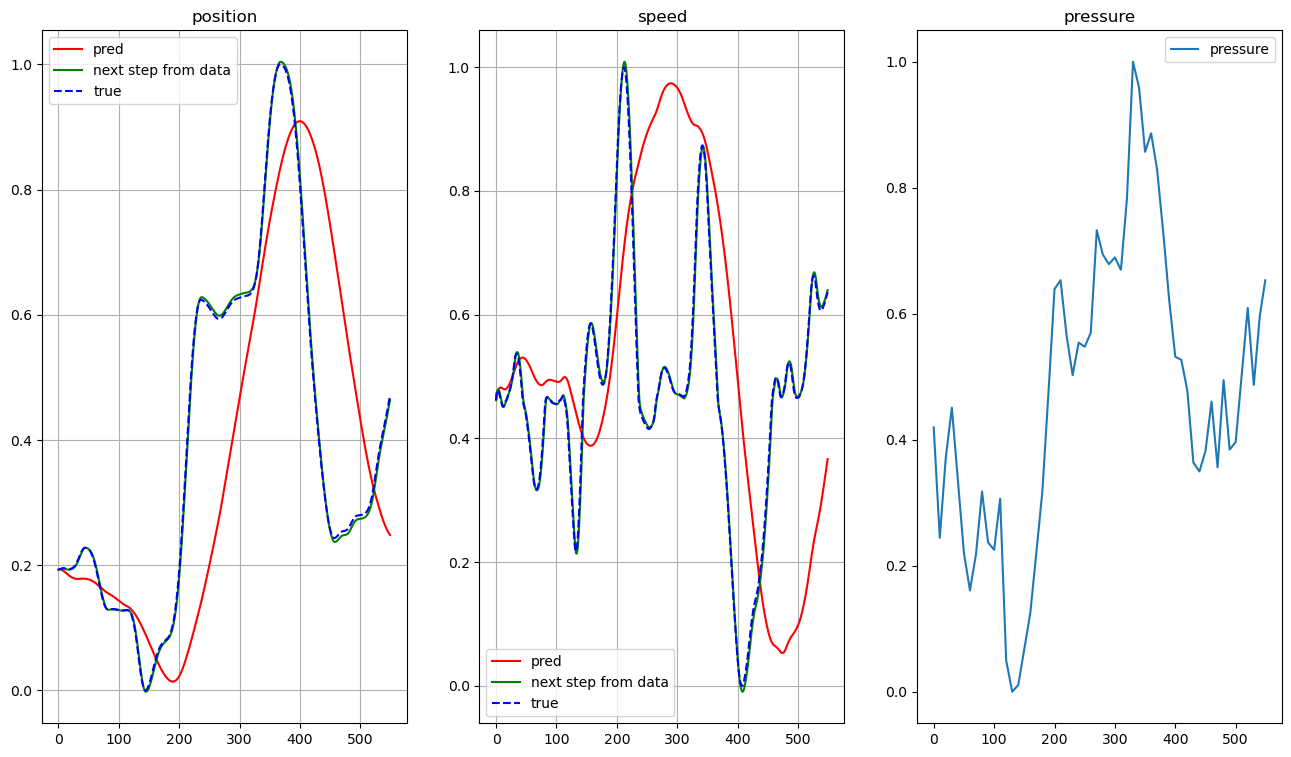

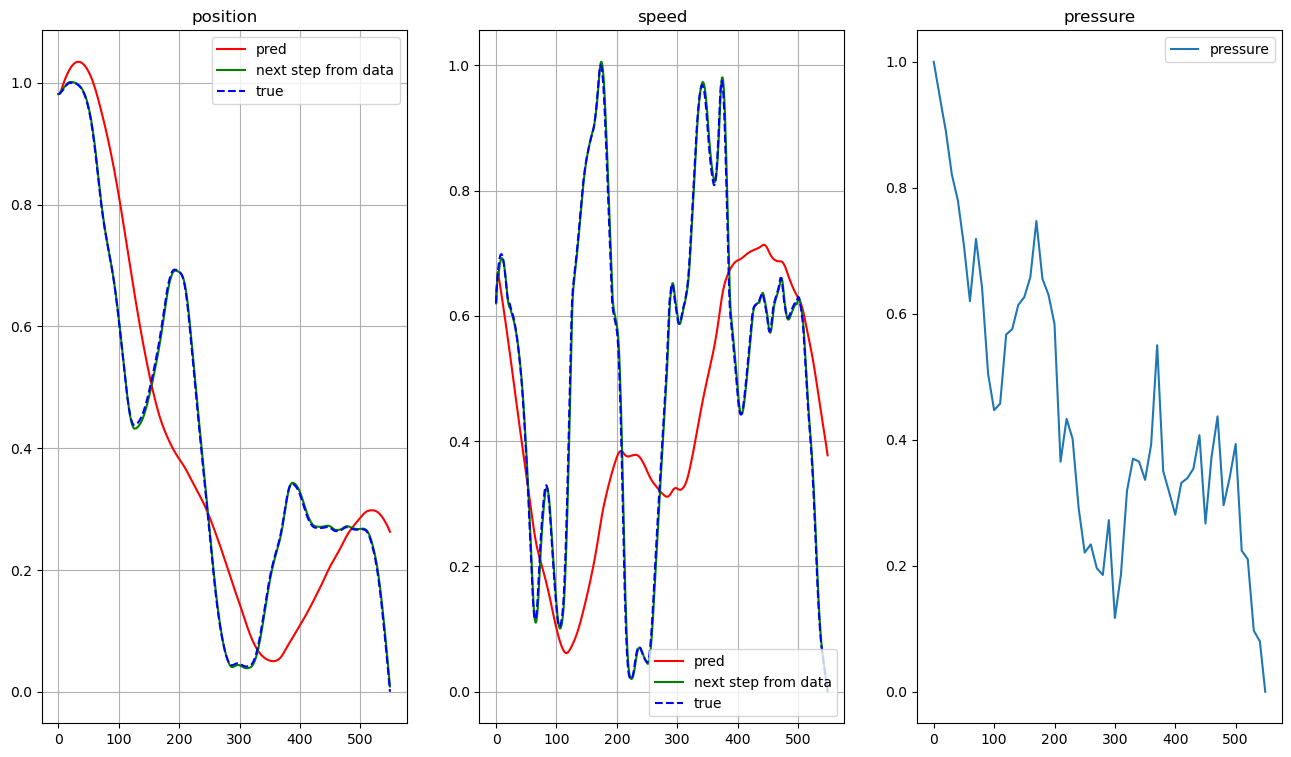

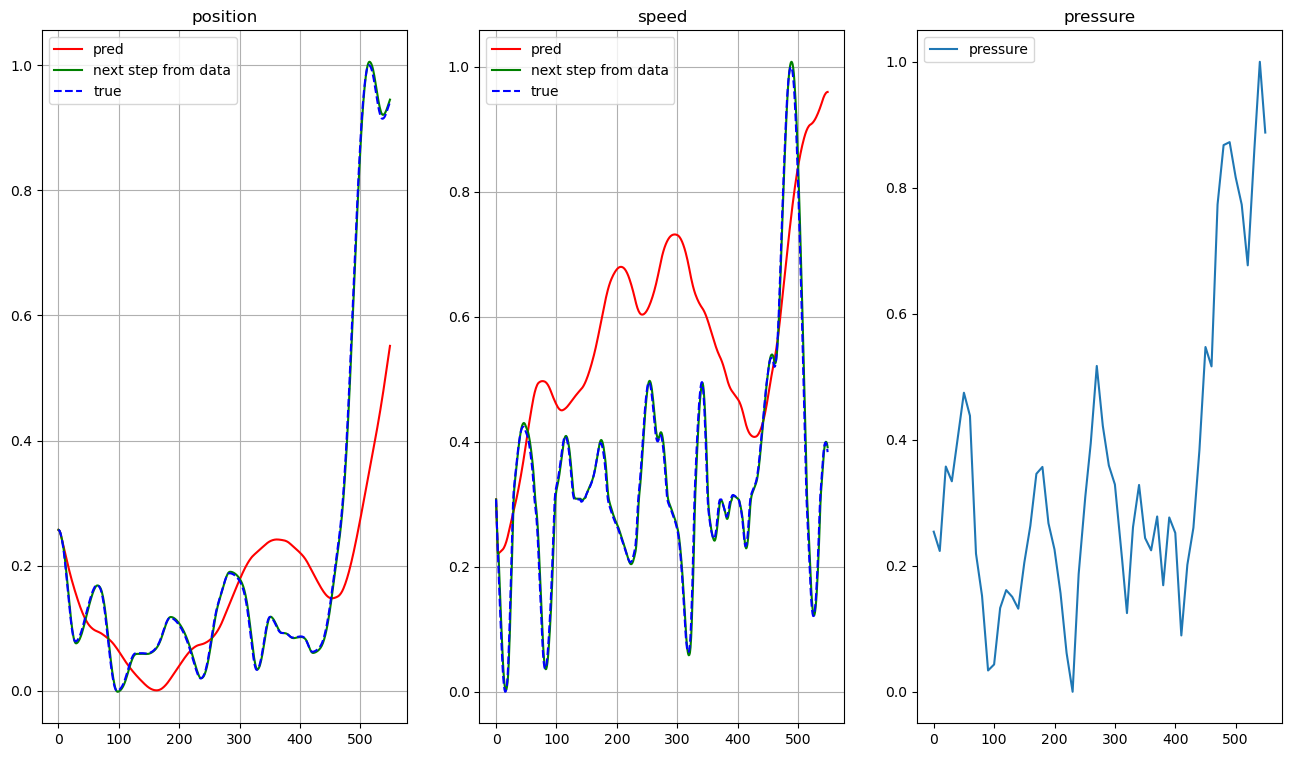

ValueError: too many values to unpack (expected 2)

In [61]:
        # Generate input data
input_data = get_data(path = "save_data_test3.csv", 
                                timesteps_from_data=0, 
                                skip_steps_start = 0,
                                skip_steps_end = 0, 
                                drop_half_timesteps = True,
                                normalise_s_w=True,
                                rescale_p=False,
                                num_inits=100)


percentage_of_data = 0.3

input_data=input_data.to(device)
# Split data into train and test sets
        #Split data into train and test sets

num_of_inits_train = int(len(input_data)*percentage_of_data)
train_inits = np.random.randint(0,len(input_data), num_of_inits_train)
train_inits = np.unique(train_inits)
test_inits = np.array([x for x in range(len(input_data)) if x not in train_inits])

# make sure we really get the specified percentage of training data..
if percentage_of_data < 0.99: 
         while len(train_inits) < num_of_inits_train * percentage_of_data:
                i = np.random.randint(0,len(test_inits),1)[0]
                train_inits = np.append(train_inits,test_inits[i])
                test_inits = np.delete(test_inits, i)


train_data = input_data[train_inits,:,:]
test_data = input_data[test_inits,:,:]
model = LSTMmodel(input_size=3, hidden_size=5, out_size=2, layers=1).to(device)

window_size = 4
h_size= 5
l_num=1
model = LSTMmodel(input_size=3, hidden_size=h_size, out_size=2, layers=l_num).to(device)

path = "Ventil_trained_NNs\lstm_ws4hs5layer1_nummer157_decay0.3.pth"#f"Ventil_trained_NNs\lstm_ws{window_size}hs{h_size}layer{l_num}_nummer8.pth"

model.load_state_dict(torch.load(path, map_location=torch.device(device)))

a,b = test(train_data, model, steps=input_data.size(dim=1), ws=window_size, plot_opt=True)
ic(a,b)